In [1]:
!pip install yfinance 

In [1]:
import pandas as pd 
import yfinance as yf

#### Step 1: Ensure yfinance is working 

In [2]:
def load_stock_ohlcv(
        ticker: str, 
        start_date: str,
        end_date: str,
        interval: str = "1d"
) -> pd.DataFrame:
    """
    Loads OHLCV (open, high, low, close, volume) for given ticker from start_date to end_date 
    using yfinance.
    """
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval, auto_adjust=True)
    df = df.reset_index()

    # Ensure we have the basic columns 
    df = df.rename(columns={"Date": "date", "Open": "open", "High": "high",
                            "Low": "low", "Close": "close", "Volume": "volume"})
    df = df[["date", "open", "high", "low", "close", "volume"]]
    return df

ticker = "AAPL"
start_date = "2025-01-01"
end_date = "2025-10-01"
ohlcv_df = load_stock_ohlcv(ticker, start_date, end_date, interval="1d")
print(ohlcv_df.head())
print(ohlcv_df.tail())

[*********************100%***********************]  1 of 1 completed

Price        date        open        high         low       close    volume
Ticker                   AAPL        AAPL        AAPL        AAPL      AAPL
0      2025-01-02  248.049444  248.218856  240.964609  242.987427  55740700
1      2025-01-03  242.499161  243.316252  241.034359  242.499161  40244100
2      2025-01-06  243.445785  246.455106  242.339711  244.133347  45045600
3      2025-01-07  242.120491  244.681407  240.496267  241.353226  40856000
4      2025-01-08  241.064237  242.847913  239.200857  241.841476  37628900
Price        date        open        high         low       close    volume
Ticker                   AAPL        AAPL        AAPL        AAPL      AAPL
181    2025-09-24  255.220001  255.740005  251.039993  252.309998  42303700
182    2025-09-25  253.210007  257.170013  251.710007  256.869995  55202100
183    2025-09-26  254.100006  257.600006  253.779999  255.460007  46076300
184    2025-09-29  254.559998  255.000000  253.009995  254.429993  40127700
185    2025-

#### Step 2: Collect data

In [17]:
import pandas as pd 
import yfinance as yf 
from typing import List 

def download_multiple_tickers(
        tickers: List[str],
        start_date: str, 
        end_date: str, 
        interval: str = "1d"
) -> pd.DataFrame:
    """
    Downloads adjusted OHLCV data for multiple tickers using yfinance and 
    returns a tidy long-format dataframe.
    """
    
    # Download all tickers together (yfinance will make multi-index columns)
    df = yf.download(tickers, start=start_date, end=end_date, interval=interval, auto_adjust=True, progress=False)

    # Flatten the multi-index columns (e.g., ('Close', 'AAPL') -> 'AAPL_Close')
    df.columns = [f"{ticker}_{col}" for col, ticker in df.columns]
    df = df.reset_index() # make 'Date' a column 

    # Melt into tidy format: one row per date-ticker 
    tidy_records = []
    for symbol in tickers:
        symbol_df = df[[
            "Date",
            f"{symbol}_Open", 
            f"{symbol}_High", 
            f"{symbol}_Low",
            f"{symbol}_Close", 
            f"{symbol}_Volume"
        ]].copy() # Copy ensure we make a superate df. 
        symbol_df.columns = ["date", "open", "high", "low", "close", "volume"] # renames
        symbol_df['ticker'] = symbol 
        tidy_records.append(symbol_df)
    
    tidy_df = pd.concat(tidy_records, ignore_index = True)
    tidy_df = tidy_df.sort_values(['ticker', 'date']).reset_index(drop=True) # sort by name and list, and resets the row numbers cleanly.
    return tidy_df 

tickers = ["META", "AAPL", "MSFT", "GOOGL"]
start_date = "2015-01-01"
end_date = "2025-10-01"

market_df = download_multiple_tickers(tickers, start_date, end_date) 
print(market_df.head(20))
print(market_df.tail(20))
print(market_df.ticker.value_counts())





1 Failed download:
['GOOGL']: Timeout('Failed to perform, curl: (28) Operation timed out after 10013 milliseconds with 78515 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


         date       open       high        low      close       volume ticker
0  2015-01-02  24.694241  24.705326  23.798606  24.237556  212818400.0   AAPL
1  2015-01-05  24.006994  24.086803  23.368523  23.554743  257142000.0   AAPL
2  2015-01-06  23.619038  23.816344  23.195606  23.556965  263188400.0   AAPL
3  2015-01-07  23.765347  23.987038  23.654501  23.887278  160423600.0   AAPL
4  2015-01-08  24.215381  24.862721  24.097883  24.805080  237458000.0   AAPL
5  2015-01-09  24.978000  25.106581  24.432638  24.831684  214798000.0   AAPL
6  2015-01-12  24.962481  24.969132  24.120054  24.219814  198603200.0   AAPL
7  2015-01-13  24.703103  25.006821  24.144441  24.434856  268367600.0   AAPL
8  2015-01-14  24.173263  24.494715  24.053549  24.341749  195826400.0   AAPL
9  2015-01-15  24.386090  24.399391  23.645641  23.681110  240056000.0   AAPL
10 2015-01-16  23.727662  23.849593  23.321966  23.497103  314053200.0   AAPL
11 2015-01-20  23.907230  24.157743  23.610164  24.102320  19959

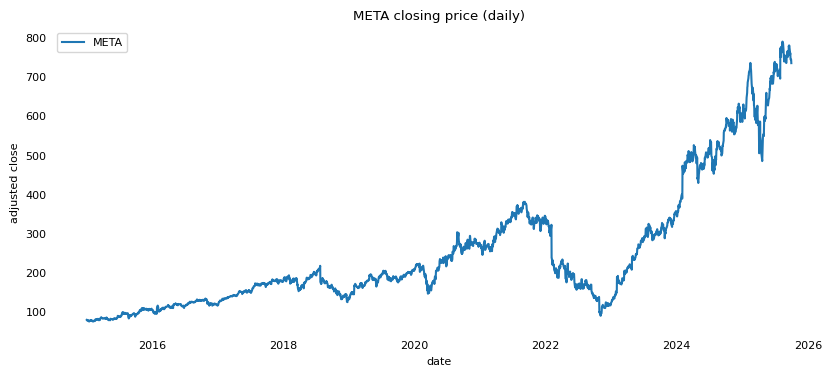

In [40]:
import matplotlib.pyplot as plt

example_ticker = "META"
meta_df = market_df[market_df["ticker"] == example_ticker]

plt.figure(figsize=(10,4))
plt.plot(meta_df["date"], meta_df["close"], label=example_ticker)
plt.title(f"{example_ticker} closing price (daily)")
plt.xlabel("date")
plt.ylabel("adjusted close")
plt.legend()
plt.show()


#### Step 3: Create charts for CNN

We will convert our historical stock data (OHLCV) into candlestick chart images and compute their future 5-day log returns.

For each ticker, we take a fixed lookback window of the last 120 trading days (~6 months), which will be used as the context the model sees. We slide this window forward day by day, producing thousands of overlapping samples.

For each window, we took 5 trading days into the future and compute the logarithmic return: 

log-return = ln(Pt+5 / Pt)

Where 
- Pt = closing price on the last day of the 120-day window. 
- Pt+5 = closing price fice days later

This value then becomes the **training target** for the CNN-VIT model.

Log-returns are for normalizing values. 


In [6]:
pip install mplfinance

Note: you may need to restart the kernel to use updated packages.


In [57]:
import os
import io
import gc
import math
import torch
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")  # headless backend for safe rendering
import matplotlib.pyplot as plt
import mplfinance as mpf
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import List

class StockCandleChartDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tickers: List[str],
        lookback_window: int,
        forecast_horizon: int,
        image_height: int = 400,
        image_width: int = 600,
        dpi: int = 150,
        include_volume: bool = True,
        cache_dir: str = "chart_cache"
    ):
        self.dataframe_all = df.copy()
        self.ticker_list = tickers
        self.lookback_window_days = lookback_window
        self.forecast_horizon_days = forecast_horizon
        self.image_height_px = image_height
        self.image_width_px = image_width
        self.include_volume = include_volume
        self.render_dpi = dpi
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)


        # Styling
        self.market_colors = mpf.make_marketcolors(
            up="#26a69a",
            down="#ef5350",
            edge="inherit",
            wick="inherit",
            volume="#1f77b4",
            alpha=1.0
        )
        self.chart_style = mpf.make_mpf_style(
            marketcolors=self.market_colors,
            gridstyle="",
            y_on_right=False,
            rc={
                "font.size": 8,
                "axes.linewidth": 0,
                "xtick.major.size": 0,
                "ytick.major.size": 0,
            }
        )

        self.sample_index = []
        for ticker_symbol in self.ticker_list: # Loop through each stock symbol
            ticker_frame = self.dataframe_all[self.dataframe_all["ticker"] == ticker_symbol].reset_index(drop=True) # Extract that stock’s full time series
            max_end_index = len(ticker_frame) - self.forecast_horizon_days - 1 # Compute how far we can slide
            for end_index in range(self.lookback_window_days, max_end_index): # Slide the window along the timeline
                self.sample_index.append((ticker_symbol, end_index)) # Record this sample

        print(f"Prepared {len(self.sample_index)} samples from {len(self.ticker_list)} tickers")

    # Draw the chart
    def _render_candlestick(self, ohlcv_window: pd.DataFrame) -> np.ndarray:
        fig_width_in = self.image_width_px / self.render_dpi
        fig_height_in = self.image_height_px / self.render_dpi

        fig, axes = mpf.plot(
            ohlcv_window,
            type="candle",
            volume=self.include_volume,
            style=self.chart_style,
            figsize=(fig_width_in, fig_height_in),
            returnfig=True,
            tight_layout=True,
            scale_padding={"left": 0.02, "right": 0.02, "top": 0.02, "bottom": 0.08},
        )

        for axis in axes:
            axis.set_axis_off()
            axis.margins(0)

        buffer = io.BytesIO()
        fig.savefig(
            buffer,
            format="png",
            dpi=self.render_dpi,
            bbox_inches="tight",
            pad_inches=0,
            facecolor="white",
            edgecolor="none",
        )
        plt.close(fig)
        buffer.seek(0)

        image_rgb = plt.imread(buffer, format="png")[..., :3]
        buffer.close()
        plt.close("all")
        gc.collect()

        image_chw = np.transpose(image_rgb.astype(np.float32), (2, 0, 1)) # Reorder the array from H×W×C → C×H×W, because PyTorch expects channels-first format.
        return image_chw

    def _render_and_save_chart(self, idx: int):
        ticker_symbol, end_index = self.sample_index[idx]
        cache_file = self.cache_dir / f"{ticker_symbol}_{end_index}.npz"
        if cache_file.exists():
            return

        ticker_frame = self.dataframe_all[self.dataframe_all["ticker"] == ticker_symbol].reset_index(drop=True)
        ohlcv_frame = ticker_frame.loc[:, ["date", "open", "high", "low", "close", "volume"]].copy()
        ohlcv_frame["date"] = pd.to_datetime(ohlcv_frame["date"])
        ohlcv_frame = ohlcv_frame.set_index("date")

        window_frame = ohlcv_frame.iloc[end_index - self.lookback_window_days: end_index]
        image_chw = self._render_candlestick(window_frame)

        future_close = float(ohlcv_frame.iloc[end_index + self.forecast_horizon_days]["close"])
        current_close = float(ohlcv_frame.iloc[end_index - 1]["close"])
        target_log_return = math.log(future_close / current_close)

        np.savez_compressed(cache_file, img=image_chw, target=target_log_return)

    def pre_render_all(self):
        print("\nPre-rendering candlestick charts (one-time build)...")
        for i in range(len(self.sample_index)):
            if i % 200 == 0:
                print(f"Rendering {i}/{len(self.sample_index)}")
            self._render_and_save_chart(i)
        print("All charts cached.")

    def __len__(self):
        return len(self.sample_index)

    def __getitem__(self, idx: int):
        ticker_symbol, end_index = self.sample_index[idx]
        cache_file = self.cache_dir / f"{ticker_symbol}_{end_index}.npz"
        if not cache_file.exists():
            raise FileNotFoundError(f"Cached chart missing: {cache_file}. Run dataset.pre_render_all() first.")
        cached = np.load(cache_file)
        image_tensor = torch.from_numpy(cached["img"])
        target_tensor = torch.tensor(float(cached["target"]), dtype=torch.float32)
        return image_tensor, target_tensor



Prepared 10304 samples from 4 tickers

Pre-rendering candlestick charts (one-time build)...
Rendering 0/10304


KeyboardInterrupt: 

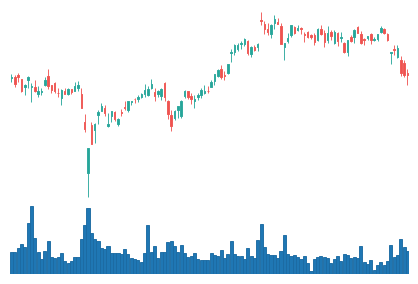

In [58]:
chart_dataset = StockCandleChartDataset(
    df=market_df,
    tickers=tickers,
    lookback_window=120,
    forecast_horizon=5,
    image_height=400,
    image_width=600,
    dpi=150
)

# One-time pre-render step (slow but permanent)
matplotlib.use("module://matplotlib_inline.backend_inline")  # for Jupyter inline plots

chart_dataset.pre_render_all()
image, target = chart_dataset[50]
print("Target log-return:", target.item())

plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title(f"(target logR={target.item():.4f})")
plt.axis("off")
plt.show()


- The green and red bars correspond to daily price moves. 
- The lower bars represent traded volume. 
- The model's target (logR=0.0461) indicates that, over the next 5 trading days following this window, the stock increased by about 4.61% in log-return terms. 

In [9]:
print(image.shape)


torch.Size([3, 396, 598])


In [10]:
print(target)

tensor(0.0461)


#### Step 4: Library imports and set seed

In [23]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torchvision import transforms, datasets 
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import time 
from datetime import datetime

def present_time():
        return datetime.now().strftime('%Y%m%d_%H%M%S')


In [12]:
import random

def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) and
    make cuDNN run in deterministic mode."""

    # Python and NumPy
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN: force repeatable convolutions
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
SEED = 42
set_seed(SEED)
print(f"Global seed set to {SEED} -- main process is now detemrinistc.")

Global seed set to 42 -- main process is now detemrinistc.


#### Step 5: The data pipeline and splitting the dataset

In [14]:
dataset_length = len(chart_dataset)

train_size = int(0.8 * dataset_length)
valid_size = dataset_length - train_size
test_size = dataset_length - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(chart_dataset, [train_size, valid_size, test_size])


In [ ]:
def build_split_indices(dataset: StockCandleChartDataset, train_ratio=0.8, val_ratio=0.1):
    ticker_groups = {}
    for i, (ticker_symbol, end_index) in enumerate(dataset.sample_index):
        ticker_groups.setdefault(ticker_symbol, []).append(i)
    
    train_idx, val_idx, test_idx = [], [], []
    for ticker, indices in ticker_groups.items():
        n = len(indices)
        train_end = int(train_ratio * n)
        val_end = train_end + int(val_ratio * n)
        train_idx.extend(indices[:train_end])
        val_idx.extend(indices[train_end:val_end])
        test_idx.extend(indices[val_end:])
    
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = build_split_indices(chart_dataset)

# Ensure sequential split for time series data
train_dataset = torch.utils.data.Subset(chart_dataset, train_idx)
valid_dataset = torch.utils.data.Subset(chart_dataset, val_idx)
test_dataset  = torch.utils.data.Subset(chart_dataset, test_idx)


In [49]:
print(train_dataset[0][1], valid_dataset[0][1])


tensor(-0.0178) tensor(0.0094)


In [39]:
batch_size = 32
num_workers = 0

In [21]:
train_loader = DataLoader(
    train_dataset, 
    batch_size = batch_size, 
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True
)

In [22]:
valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle=False,
    num_workers = num_workers,
    pin_memory = True
)

In [23]:
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory = True
)

#### Step 6: Define the CNN Model

In [24]:
class ConvNet(nn.Module):
    def __init__(self, in_channels: int = 3, feature_channels: int = 64):
        super().__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(in_channels, feature_channels // 2, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels // 2),

            # Conv Block 2 - 5
            nn.Conv2d(feature_channels // 2, feature_channels, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels),
            nn.Conv2d(feature_channels, feature_channels * 2, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 2),
            nn.Conv2d(feature_channels * 2, feature_channels * 4, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 4),
            nn.Conv2d(feature_channels * 4, feature_channels * 8, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 8),
            nn.Conv2d(feature_channels * 8, feature_channels * 16, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 16),
        )

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        return self.features(x)

#### Step 7: PatchEmbed

In [25]:
class PatchEmbed(nn.Module):
    def __init__(self, input_channel = 1024, embed_dim = 768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1) # 1 x 1 conv

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2) # B, L, D
        return x

#### Step 8: Multi-head self-attention (MHSA) module

In [26]:
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads 
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2) # B, heads, N, d
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1) * self.scale)
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

#### Step 9: TransformerBlock

In [27]:
class TransformerBlcok(nn.Module):
    def __init__(self, dim, heads, mlp_ratio = 4, dropout = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

#### Step 10: ViT model

In [28]:
class ViT(nn.Module):
    def __init__(self, in_ch = 1024, embed_dim = 768, depth = 6, heads = 8, mlp_ratio = 4., dropout = 0.1, max_tokens = 100):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)
        self.cls = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlcok(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, 1) # Single output for regression

    def forward(self, x):
        x = self.patch(x)
        B, L, _ = x.shape
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat((cls, x), 1)
        x = x + self.pos[:, :L + 1]
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])

#### Step 11: CNN-ViT hybrid model

In [29]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, in_channels = 3, embed_dim = 768, depth = 6, heads = 8):
        super().__init__()
        self.cnn = ConvNet(in_channels = in_channels)
        self.vit = ViT(
            embed_dim = embed_dim,
            depth = depth,
            heads = heads
        )
    
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

#### Step 12: Model Training

In [30]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum = 0
    # correct = 0
    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training ")):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x).squeeze()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        # correct += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset)
# , correct / len(loader.dataset)


#### Step 13: Model evaluation

In [31]:
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum  = 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x).squeeze()
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
    return loss_sum / len(loader.dataset)


#### Step 14: Test

In [32]:
def test(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum = 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Testing   ")):
            x, y = x.to(device), y.to(device)
            out = model(x).squeeze()
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
    return loss_sum / len(loader.dataset)

#### Step 14: Training loop

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

lr = 0.0003
epochs = 15 
attn_heads = 12
depth = 18
embed_dim = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"model.pth"

model = CNN_ViT_Hybrid(
    in_channels=3,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
# tr_acc_all = []
# te_acc_all = []

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch: 02d}/{epochs:02d} started at {present_time()}")
    tr_loss = train(model, train_loader, optimizer, criterion, device)
    te_loss = evaluate(model, valid_loader, criterion, device)
    ##
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} |"
          f"val loss {te_loss:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    # tr_acc_all.append(tr_acc)
    # te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # save the best model 
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss: .04f}) lower than previous best loss ({best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


print(f"\nTraining completed!")

# Test on test set
print(f"\n{'='*60}")
print("Testing on held-out test set...")
print(f"{'='*60}")

# Load best model
model.load_state_dict(torch.load(model_dict_name))

# Test
test_loss = test(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.6f}")


Training the model on cuda
epochs:15 | batch:32 | attn_heads:12 | depth:18 | embed_dim:768

Epoch  1/15 started at 20251031_232945


Validation: 100%|██████████| 33/33 [00:19<00:00,  1.72it/s]


Epoch 01 | train loss 0.6105 |val loss 0.0016 | in  249.25s
Current loss ( 0.0016) lower than previous best loss (inf), Saving current model state

Epoch  2/15 started at 20251031_233354


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.72it/s]


Epoch 02 | train loss 0.0031 |val loss 0.0022 | in  152.33s

Epoch  3/15 started at 20251031_233627


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.85it/s]


Epoch 03 | train loss 0.0031 |val loss 0.0016 | in  149.63s

Epoch  4/15 started at 20251031_233856


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.67it/s]


Epoch 04 | train loss 0.0031 |val loss 0.0020 | in  151.50s

Epoch  5/15 started at 20251031_234128


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.67it/s]


Epoch 05 | train loss 0.0030 |val loss 0.0017 | in  152.08s

Epoch  6/15 started at 20251031_234400


Validation: 100%|██████████| 33/33 [00:09<00:00,  3.62it/s]


Epoch 06 | train loss 0.0029 |val loss 0.0017 | in  154.43s

Epoch  7/15 started at 20251031_234634


Validation: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]


Epoch 07 | train loss 0.0029 |val loss 0.0020 | in  154.47s

Epoch  8/15 started at 20251031_234909


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.79it/s]


Epoch 08 | train loss 0.0029 |val loss 0.0018 | in  153.15s

Epoch  9/15 started at 20251031_235142


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.83it/s]


Epoch 09 | train loss 0.0030 |val loss 0.0020 | in  147.21s

Epoch  10/15 started at 20251031_235409


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.73it/s]


Epoch 10 | train loss 0.0031 |val loss 0.0020 | in  147.92s

Epoch  11/15 started at 20251031_235637


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.83it/s]


Epoch 11 | train loss 0.0028 |val loss 0.0030 | in  149.28s

Epoch  12/15 started at 20251031_235906


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.73it/s]


Epoch 12 | train loss 0.0026 |val loss 0.0063 | in  147.73s

Epoch  13/15 started at 20251101_000134


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.71it/s]


Epoch 13 | train loss 0.0027 |val loss 0.0021 | in  148.66s

Epoch  14/15 started at 20251101_000403


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 14 | train loss 0.0026 |val loss 0.0020 | in  146.62s

Epoch  15/15 started at 20251101_000629


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 15 | train loss 0.0026 |val loss 0.0040 | in  146.46s
epochs:15 | batch:32 | attn_heads:12 | depth:18 | embed_dim:768

Training completed!

Testing on held-out test set...


Testing   : 100%|██████████| 33/33 [00:18<00:00,  1.83it/s]


Test Loss: 0.002093


test loss = 
sqrt(0.002093)​≈0.0457
e0.0457−1≈4.68%

In [34]:
import torch
import numpy as np
from tqdm import tqdm

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Collecting predictions"):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        preds = model(images).squeeze()   # shape [B]
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Flatten
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²:  {r2:.4f}")


MSE: 0.002093
MAE: 0.034754
R²:  -0.0064


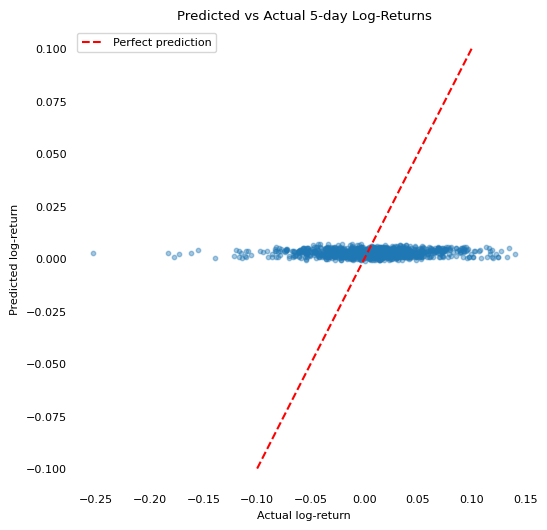

In [50]:
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")  # for Jupyter inline plots

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4, s=10)
plt.xlabel("Actual log-return")
plt.ylabel("Predicted log-return")
plt.title("Predicted vs Actual 5-day Log-Returns")
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--', label='Perfect prediction')
plt.legend()
plt.grid(True)
plt.show()


The performance of this stock price prediction model did not do too well. We will now initiate building a classification model instead. However, before we do so let us try a different criterion.

MSE might be too forgiving to the errors. We will try Huber loss instead.

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

lr = 0.0003
epochs = 15 
attn_heads = 12
depth = 18
embed_dim = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"model.pth"

model = CNN_ViT_Hybrid(
    in_channels=3,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)

criterion = nn.HuberLoss(delta=0.1, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
# tr_acc_all = []
# te_acc_all = []

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch: 02d}/{epochs:02d} started at {present_time()}")
    tr_loss = train(model, train_loader, optimizer, criterion, device)
    te_loss = evaluate(model, valid_loader, criterion, device)
    ##
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} |"
          f"val loss {te_loss:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    # tr_acc_all.append(tr_acc)
    # te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # save the best model 
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss: .04f}) lower than previous best loss ({best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


print(f"\nTraining completed!")

# Test on test set
print(f"\n{'='*60}")
print("Testing on held-out test set...")
print(f"{'='*60}")

# Load best model
model.load_state_dict(torch.load(model_dict_name))

# Test
test_loss = test(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.6f}")


Training the model on cuda
epochs:15 | batch:32 | attn_heads:12 | depth:18 | embed_dim:768

Epoch  1/15 started at 20251103_231336


Validation: 100%|██████████| 33/33 [00:20<00:00,  1.60it/s]


Epoch 01 | train loss 0.0145 |val loss 0.0026 | in  250.85s
Current loss ( 0.0026) lower than previous best loss (inf), Saving current model state

Epoch  2/15 started at 20251103_231748


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 02 | train loss 0.0028 |val loss 0.0038 | in  148.65s

Epoch  3/15 started at 20251103_232017


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 03 | train loss 0.0019 |val loss 0.0010 | in  146.40s
Current loss ( 0.0010) lower than previous best loss (0.0026), Saving current model state

Epoch  4/15 started at 20251103_232243


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 04 | train loss 0.0020 |val loss 0.0009 | in  146.83s
Current loss ( 0.0009) lower than previous best loss (0.0010), Saving current model state

Epoch  5/15 started at 20251103_232511


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 05 | train loss 0.0016 |val loss 0.0017 | in  147.15s

Epoch  6/15 started at 20251103_232738


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 06 | train loss 0.0014 |val loss 0.0013 | in  146.56s

Epoch  7/15 started at 20251103_233004


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 07 | train loss 0.0013 |val loss 0.0015 | in  146.72s

Epoch  8/15 started at 20251103_233231


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.88it/s]


Epoch 08 | train loss 0.0012 |val loss 0.0009 | in  146.39s
Current loss ( 0.0009) lower than previous best loss (0.0009), Saving current model state

Epoch  9/15 started at 20251103_233458


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 09 | train loss 0.0014 |val loss 0.0017 | in  146.68s

Epoch  10/15 started at 20251103_233725


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 10 | train loss 0.0012 |val loss 0.0027 | in  146.64s

Epoch  11/15 started at 20251103_233952


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.79it/s]


Epoch 11 | train loss 0.0012 |val loss 0.0009 | in  146.81s

Epoch  12/15 started at 20251103_234219


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.88it/s]


Epoch 12 | train loss 0.0012 |val loss 0.0030 | in  146.65s

Epoch  13/15 started at 20251103_234445


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 13 | train loss 0.0011 |val loss 0.0010 | in  146.57s

Epoch  14/15 started at 20251103_234712


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 14 | train loss 0.0011 |val loss 0.0010 | in  146.56s

Epoch  15/15 started at 20251103_234938


Validation: 100%|██████████| 33/33 [00:08<00:00,  3.84it/s]


Epoch 15 | train loss 0.0012 |val loss 0.0010 | in  147.13s
epochs:15 | batch:32 | attn_heads:12 | depth:18 | embed_dim:768

Training completed!

Testing on held-out test set...


Testing   : 100%|██████████| 33/33 [00:18<00:00,  1.75it/s]


Test Loss: 0.001099


In [52]:
import torch
import numpy as np
from tqdm import tqdm

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Collecting predictions"):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        preds = model(images).squeeze()   # shape [B]
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Flatten
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)


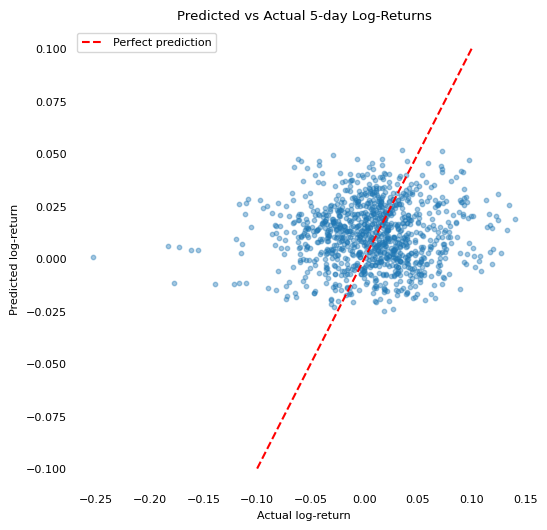

In [53]:
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")  # for Jupyter inline plots

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4, s=10)
plt.xlabel("Actual log-return")
plt.ylabel("Predicted log-return")
plt.title("Predicted vs Actual 5-day Log-Returns")
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--', label='Perfect prediction')
plt.legend()
plt.grid(True)
plt.show()


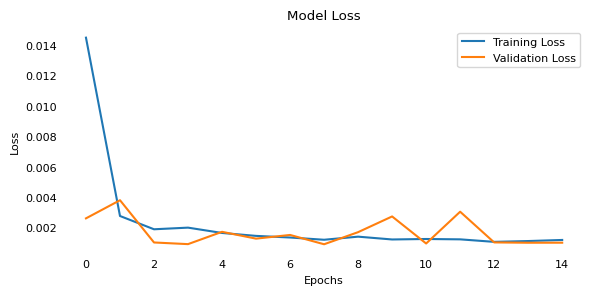

In [55]:
fig_w, fig_h = 6, 3
fig, axs = plt.subplots(figsize=(fig_w, fig_h))

# Plot Accuracy on the first subplot 
axs.plot(tr_loss_all, label="Training Loss")
axs.plot(te_loss_all, label="Validation Loss")
axs.set_title("Model Loss")
axs.set_xlabel("Epochs")
axs.set_ylabel("Loss")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()


We will now move on to the classification model.

In [4]:
import os
import io
import gc
import math
import torch
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")  # headless backend for safe rendering
import matplotlib.pyplot as plt
import mplfinance as mpf
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import List

class StockCandleChartDataset_Class(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tickers: List[str],
        lookback_window: int,
        forecast_horizon: int,
        image_height: int = 400,
        image_width: int = 600,
        dpi: int = 150,
        include_volume: bool = True,
        cache_dir: str = "chart_cache_class"
    ):
        self.dataframe_all = df.copy()
        self.ticker_list = tickers
        self.lookback_window_days = lookback_window
        self.forecast_horizon_days = forecast_horizon
        self.image_height_px = image_height
        self.image_width_px = image_width
        self.include_volume = include_volume
        self.render_dpi = dpi
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)


        # Styling
        self.market_colors = mpf.make_marketcolors(
            up="#26a69a",
            down="#ef5350",
            edge="inherit",
            wick="inherit",
            volume="#1f77b4",
            alpha=1.0
        )
        self.chart_style = mpf.make_mpf_style(
            marketcolors=self.market_colors,
            gridstyle="",
            y_on_right=False,
            rc={
                "font.size": 8,
                "axes.linewidth": 0,
                "xtick.major.size": 0,
                "ytick.major.size": 0,
            }
        )

        self.sample_index = []
        for ticker_symbol in self.ticker_list: # Loop through each stock symbol
            ticker_frame = self.dataframe_all[self.dataframe_all["ticker"] == ticker_symbol].reset_index(drop=True) # Extract that stock’s full time series
            max_end_index = len(ticker_frame) - self.forecast_horizon_days - 1 # Compute how far we can slide
            for end_index in range(self.lookback_window_days, max_end_index): # Slide the window along the timeline
                self.sample_index.append((ticker_symbol, end_index)) # Record this sample

        print(f"Prepared {len(self.sample_index)} samples from {len(self.ticker_list)} tickers")

    # Draw the chart
    def _render_candlestick(self, ohlcv_window: pd.DataFrame) -> np.ndarray:
        fig_width_in = self.image_width_px / self.render_dpi
        fig_height_in = self.image_height_px / self.render_dpi

        fig, axes = mpf.plot(
            ohlcv_window,
            type="candle",
            volume=self.include_volume,
            style=self.chart_style,
            figsize=(fig_width_in, fig_height_in),
            returnfig=True,
            tight_layout=True,
            scale_padding={"left": 0.02, "right": 0.02, "top": 0.02, "bottom": 0.08},
        )

        for axis in axes:
            axis.set_axis_off()
            axis.margins(0)

        buffer = io.BytesIO()
        fig.savefig(
            buffer,
            format="png",
            dpi=self.render_dpi,
            bbox_inches="tight",
            pad_inches=0,
            facecolor="white",
            edgecolor="none",
        )
        plt.close(fig)
        buffer.seek(0)

        image_rgb = plt.imread(buffer, format="png")[..., :3]
        buffer.close()
        plt.close("all")
        gc.collect()

        image_chw = np.transpose(image_rgb.astype(np.float32), (2, 0, 1)) # Reorder the array from H×W×C → C×H×W, because PyTorch expects channels-first format.
        return image_chw

    # Make changes here for classification data.
    def _render_and_save_chart(self, idx: int):
        ticker_symbol, end_index = self.sample_index[idx]
        cache_file = self.cache_dir / f"{ticker_symbol}_{end_index}.npz"
        if cache_file.exists():
            return

        ticker_frame = self.dataframe_all[self.dataframe_all["ticker"] == ticker_symbol].reset_index(drop=True)
        ohlcv_frame = ticker_frame.loc[:, ["date", "open", "high", "low", "close", "volume"]].copy()
        ohlcv_frame["date"] = pd.to_datetime(ohlcv_frame["date"])
        ohlcv_frame = ohlcv_frame.set_index("date")

        window_frame = ohlcv_frame.iloc[end_index - self.lookback_window_days: end_index]
        # window_frame = ohlcv_frame.iloc[end_index - self.lookback_window_days - 1: end_index - 1]
        image_chw = self._render_candlestick(window_frame)

        future_close = float(ohlcv_frame.iloc[end_index + self.forecast_horizon_days]["close"])
        current_close = float(ohlcv_frame.iloc[end_index - 1]["close"])
        target_log_return = math.log(future_close / current_close)

        if target_log_return > 0:
            target_class = 1
        else:
            target_class = 0

        np.savez_compressed(cache_file, img=image_chw, target=target_class)

    def pre_render_all(self):
        print("\nPre-rendering candlestick charts (one-time build)...")
        for i in range(len(self.sample_index)):
            if i % 200 == 0:
                print(f"Rendering {i}/{len(self.sample_index)}")
            self._render_and_save_chart(i)
        print("All charts cached.")

    def __len__(self):
        return len(self.sample_index)

    def __getitem__(self, idx: int):
        ticker_symbol, end_index = self.sample_index[idx]
        cache_file = self.cache_dir / f"{ticker_symbol}_{end_index}.npz"
        if not cache_file.exists():
            raise FileNotFoundError(f"Cached chart missing: {cache_file}. Run dataset.pre_render_all() first.")
        cached = np.load(cache_file)
        image_tensor = torch.from_numpy(cached["img"])
        # target_tensor = torch.tensor(float(cached["target"]), dtype=torch.float32)
        target_tensor = torch.tensor(int(cached["target"]), dtype=torch.long)
        return image_tensor, target_tensor



Prepared 10304 samples from 4 tickers

Pre-rendering candlestick charts (one-time build)...
Rendering 0/10304
Rendering 200/10304
Rendering 400/10304
Rendering 600/10304
Rendering 800/10304
Rendering 1000/10304
Rendering 1200/10304
Rendering 1400/10304
Rendering 1600/10304
Rendering 1800/10304
Rendering 2000/10304
Rendering 2200/10304
Rendering 2400/10304
Rendering 2600/10304
Rendering 2800/10304
Rendering 3000/10304
Rendering 3200/10304
Rendering 3400/10304
Rendering 3600/10304
Rendering 3800/10304
Rendering 4000/10304
Rendering 4200/10304
Rendering 4400/10304
Rendering 4600/10304
Rendering 4800/10304
Rendering 5000/10304
Rendering 5200/10304
Rendering 5400/10304
Rendering 5600/10304
Rendering 5800/10304
Rendering 6000/10304
Rendering 6200/10304
Rendering 6400/10304
Rendering 6600/10304
Rendering 6800/10304
Rendering 7000/10304
Rendering 7200/10304
Rendering 7400/10304
Rendering 7600/10304
Rendering 7800/10304
Rendering 8000/10304
Rendering 8200/10304
Rendering 8400/10304
Rendering 86

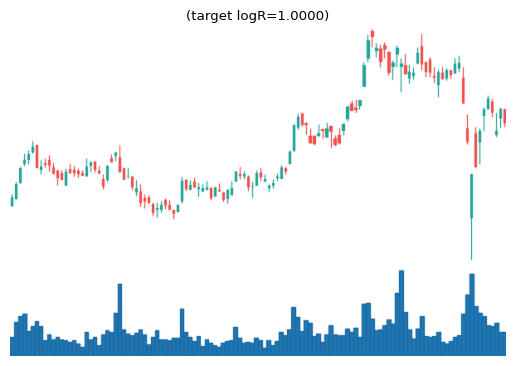

In [61]:
chart_dataset_class = StockCandleChartDataset_Class(
    df=market_df,
    tickers=tickers,
    lookback_window=120,
    forecast_horizon=5,
    image_height=400,
    image_width=600,
    dpi=150,
)

# One-time pre-render step (slow but permanent)
matplotlib.use("module://matplotlib_inline.backend_inline")  # for Jupyter inline plots

chart_dataset_class.pre_render_all()
image, target = chart_dataset_class[50]
print("Target log-return:", target.item())

plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title(f"(target logR={target.item():.4f})")
plt.axis("off")
plt.show()


In [63]:
def build_split_indices(dataset: StockCandleChartDataset_Class, train_ratio=0.8, val_ratio=0.1):
    ticker_groups = {}
    for i, (ticker_symbol, end_index) in enumerate(dataset.sample_index):
        ticker_groups.setdefault(ticker_symbol, []).append(i)
    
    train_idx, val_idx, test_idx = [], [], []
    for ticker, indices in ticker_groups.items():
        n = len(indices)
        train_end = int(train_ratio * n)
        val_end = train_end + int(val_ratio * n)
        train_idx.extend(indices[:train_end])
        val_idx.extend(indices[train_end:val_end])
        test_idx.extend(indices[val_end:])
    
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = build_split_indices(chart_dataset_class)

# Ensure sequential split for time series data
train_dataset = torch.utils.data.Subset(chart_dataset_class, train_idx)
valid_dataset = torch.utils.data.Subset(chart_dataset_class, val_idx)
test_dataset  = torch.utils.data.Subset(chart_dataset_class, test_idx)


In [20]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

8240
1028
1036


In [24]:
class ConvNet(nn.Module):
    def __init__(self, in_channels: int = 3, feature_channels: int = 64):
        super().__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(in_channels, feature_channels // 2, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels // 2),

            # Conv Block 2 - 5
            nn.Conv2d(feature_channels // 2, feature_channels, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels),
            nn.Conv2d(feature_channels, feature_channels * 2, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 2),
            nn.Conv2d(feature_channels * 2, feature_channels * 4, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 4),
            nn.Conv2d(feature_channels * 4, feature_channels * 8, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 8),
            nn.Conv2d(feature_channels * 8, feature_channels * 16, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 16),
        )

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        return self.features(x)

In [25]:
class PatchEmbed(nn.Module):
    def __init__(self, input_channel = 1024, embed_dim = 768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size = 1)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [26]:
class MHSA(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.heads = heads 
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2) # B, heads, N, d
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1) * self.scale)
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

In [27]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio = 4, dropout = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [28]:
class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=2, embed_dim=768, depth=6, heads=8, mlp_ratio=4., dropout=0.1, max_tokens=100):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim) # 1 x 1 conv
        self.cls = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                        # x: (B,C,H,W)
        x = self.patch(x)                        # (B, L, D)
        B, L, _ = x.shape                        
        cls = self.cls.expand(B, -1, -1)         # (B, 1, D)
        x = torch.cat((cls, x), 1)               # (B, L+1, D)
        x = x + self.pos[:, :L + 1]              # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])     # CLS token

In [29]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, in_channels=3, num_classes = 2, embed_dim = 768, depth = 6, heads = 8):
        super().__init__()
        self.cnn = ConvNet(in_channels=in_channels)
        self.vit = ViT(
            num_classes=num_classes,
            embed_dim = embed_dim,
            depth = depth,
            heads = heads
            )
    
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

In [30]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training ")):
        x, y = x.to(device), y.to(device)
        y = y.long()
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

In [31]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    scaler = torch.cuda.amp.GradScaler()

    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training ")):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        y = y.long()
        optimizer.zero_grad()

        # 🔥 Use mixed precision for forward + loss
        with torch.cuda.amp.autocast():
            out = model(x)
            loss = criterion(out, y)

        # 🔥 Scale the loss before backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return loss_sum / len(loader.dataset), correct / len(loader.dataset)


In [110]:
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

In [111]:
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum, correct = 0, 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y = y.long()
            with torch.cuda.amp.autocast():  # ✅
                out = model(x)
                loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)


In [34]:
def test(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Testing")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

In [112]:
def test(model, loader, criterion, device):
    model.eval()
    loss_sum, correct = 0, 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Testing")):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y = y.long()
            with torch.cuda.amp.autocast():  # ✅
                out = model(x)
                loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)


In [36]:

lr = 0.0003
epochs = 10
attn_heads = 12
depth = 18
embed_dim = 768
batch_size = 32
num_cls = 2


In [40]:
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True
)

In [41]:
valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle=False,
    num_workers = num_workers,
    pin_memory = True
)

In [42]:
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory = True
)

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")


print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_state_dict.pth"

model = CNN_ViT_Hybrid(
    in_channels=3,
    num_classes=num_cls,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = [] 

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch: 02d}/{epochs:02d} started at {present_time()}")
    tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, device) # Former gets the loss, latter gets the acc (just the way it is)
    te_loss, te_acc = evaluate(model, valid_loader, criterion, device)
    ##
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # save the best model 
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)
        
print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


print(f"\nTraining completed!")

# Test on test set
print(f"\n{'='*60}")
print("Testing on held-out test set...")
print(f"{'='*60}")

# Load best model
model.load_state_dict(torch.load(model_dict_name))

# Test
# test_loss = test(model, test_loader, criterion, device)
test_loss, test_acc = test(model, test_loader, criterion, device)
# print(f"\nTest Loss: {test_loss:.6f}")
print(f"\nTest Loss: {test_loss:.6f} | Test Accuracy: {test_acc:.6f}")


Training the model on cuda
epochs:10 | batch:32 | attn_heads:12 | depth:18 | embed_dim:768


C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\152256325.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch  1/10 started at 20251113_151403


Training :   0%|          | 0/258 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\152256325.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/33 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\771255876.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # ✅
Validation: 100%|██████████| 33/33 [00:17<00:00,  1.87it/s]


Epoch 01 | train loss 0.7592 acc 0.5464 | val loss 0.6781 acc 0.5914 | in  193.81s
Current loss (0.6781) lower than previous best loss (inf), Saving current model state

Epoch  2/10 started at 20251113_151717


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.70it/s]


Epoch 02 | train loss 0.6945 acc 0.5517 | val loss 0.6783 acc 0.5914 | in  103.80s

Epoch  3/10 started at 20251113_151901


Validation: 100%|██████████| 33/33 [00:06<00:00,  4.72it/s]


Epoch 03 | train loss 0.6887 acc 0.5614 | val loss 0.6963 acc 0.5914 | in  102.88s

Epoch  4/10 started at 20251113_152044


Validation: 100%|██████████| 33/33 [00:06<00:00,  4.77it/s]


Epoch 04 | train loss 0.6879 acc 0.5614 | val loss 0.6794 acc 0.5914 | in  102.13s

Epoch  5/10 started at 20251113_152226


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.69it/s]


Epoch 05 | train loss 0.6879 acc 0.5692 | val loss 0.6836 acc 0.5914 | in  103.99s

Epoch  6/10 started at 20251113_152410


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.67it/s]


Epoch 06 | train loss 0.6886 acc 0.5606 | val loss 0.6841 acc 0.5914 | in  103.67s

Epoch  7/10 started at 20251113_152554


Validation: 100%|██████████| 33/33 [00:06<00:00,  4.73it/s]


Epoch 07 | train loss 0.6895 acc 0.5716 | val loss 0.6783 acc 0.5914 | in  102.82s

Epoch  8/10 started at 20251113_152737


Validation: 100%|██████████| 33/33 [00:06<00:00,  4.73it/s]


Epoch 08 | train loss 0.6836 acc 0.5805 | val loss 0.6780 acc 0.5914 | in  101.28s
Current loss (0.6780) lower than previous best loss (0.6781), Saving current model state

Epoch  9/10 started at 20251113_152919


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.70it/s]


Epoch 09 | train loss 0.6824 acc 0.5784 | val loss 0.6790 acc 0.5914 | in  101.17s

Epoch  10/10 started at 20251113_153100


Validation: 100%|██████████| 33/33 [00:06<00:00,  4.73it/s]


Epoch 10 | train loss 0.6842 acc 0.5733 | val loss 0.6794 acc 0.5914 | in  101.04s
epochs:10 | batch:32 | attn_heads:12 | depth:18 | embed_dim:768

Training completed!

Testing on held-out test set...


Testing: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Test Loss: 0.677747 | Test Accuracy: 0.594595


In [321]:
targets = [np.load(f)["target"] for f in Path("chart_cache_class").glob("*.npz")]
print(pd.Series(targets).value_counts(normalize=True))


1    0.586471
0    0.413529
Name: proportion, dtype: float64


Potential problems we could fix: 
- Data imbalance, 58.6% of data is labeled 1, and 41.4% is labeled 0.
- Pixel normalization.

So it turns out the accuracy currently matches the amount of 1s we have in the data, which may mean that our model is just predicting 1s for every chart. Which is not helpful, we will confirm this hypithesis via a confusion matrix. Regardless, instead of cross-entropy loss, we could use focal loss which penalizes overconfident wrong predictions.

I also thought I have dropout in my model to prevent laxy learning but maybe not. I'll have to check, I may also have to add weight decay. 

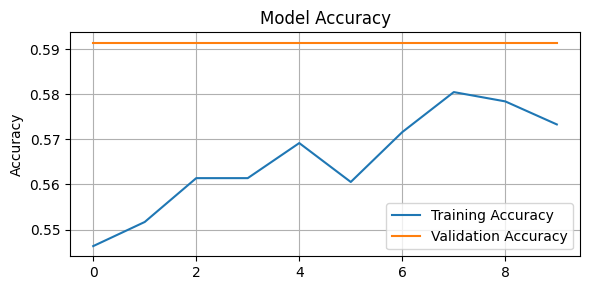

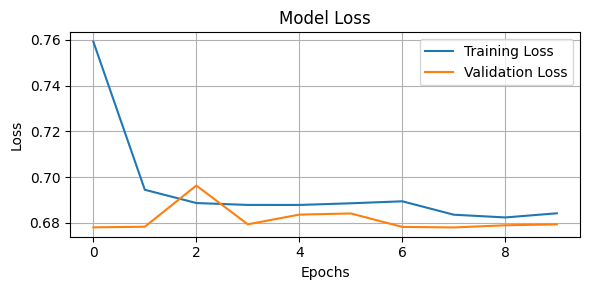

In [44]:
import matplotlib.pyplot as plt


fig_w, fig_h = 6, 3
fig, axs = plt.subplots(figsize=(fig_w, fig_h))

# Plot Accuracy on the first subplot 
axs.plot(tr_acc_all, label="Training Accuracy")
axs.plot(te_acc_all, label="Validation Accuracy")
axs.set_title("Model Accuracy")
axs.set_ylabel("Accuracy")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(figsize=(fig_w, fig_h))

# Plot loss on the second subplot 
axs.plot(tr_loss_all, label="Training Loss")
axs.plot(te_loss_all, label="Validation Loss")
axs.set_title("Model Loss")
axs.set_xlabel("Epochs")
axs.set_ylabel("Loss")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

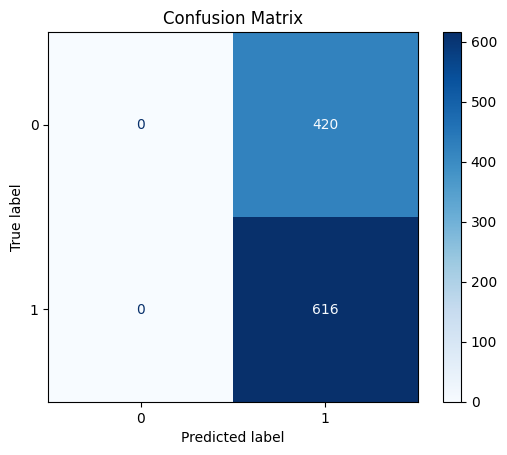

Class 0: 0.00% accuracy
Class 1: 100.00% accuracy


In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient calculation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally normalize it (set normalize='true' for percentages)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# If you want class-wise accuracy:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i, acc in enumerate(np.diag(cm_normalized)):
    print(f"Class {i}: {acc*100:.2f}% accuracy")


Bingo.

In [48]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        """
        inputs: (N, C) logits
        targets: (N,) class indices
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # Probability of true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")


print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_state_dict.pth"

model = CNN_ViT_Hybrid(
    in_channels=3,
    num_classes=num_cls,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)

criterion = FocalLoss(alpha=1, gamma=5)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = [] 

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch: 02d}/{epochs:02d} started at {present_time()}")
    tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, device) # Former gets the loss, latter gets the acc (just the way it is)
    te_loss, te_acc = evaluate(model, valid_loader, criterion, device)
    ##
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # save the best model 
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)
        
print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


print(f"\nTraining completed!")

# Test on test set
print(f"\n{'='*60}")
print("Testing on held-out test set...")
print(f"{'='*60}")

# Load best model
model.load_state_dict(torch.load(model_dict_name))

# Test
# test_loss = test(model, test_loader, criterion, device)
test_loss, test_acc = test(model, test_loader, criterion, device)
# print(f"\nTest Loss: {test_loss:.6f}")
print(f"\nTest Loss: {test_loss:.6f} | Test Accuracy: {test_acc:.6f}")


Training the model on cuda
epochs:10 | batch:32 | attn_heads:12 | depth:18 | embed_dim:768


C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\152256325.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch  1/10 started at 20251113_161428


Training :   0%|          | 0/258 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\152256325.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/33 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\771255876.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # ✅
Validation: 100%|██████████| 33/33 [00:07<00:00,  4.62it/s]


Epoch 01 | train loss 0.1729 acc 0.5453 | val loss 0.0216 acc 0.5914 | in  105.06s
Current loss (0.0216) lower than previous best loss (inf), Saving current model state

Epoch  2/10 started at 20251113_161614


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]


Epoch 02 | train loss 0.0219 acc 0.5481 | val loss 0.0214 acc 0.5914 | in  104.53s
Current loss (0.0214) lower than previous best loss (0.0216), Saving current model state

Epoch  3/10 started at 20251113_161759


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.61it/s]


Epoch 03 | train loss 0.0221 acc 0.5433 | val loss 0.0248 acc 0.5914 | in  106.90s

Epoch  4/10 started at 20251113_161946


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.40it/s]


Epoch 04 | train loss 0.0218 acc 0.5603 | val loss 0.0226 acc 0.5914 | in  113.51s

Epoch  5/10 started at 20251113_162139


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.55it/s]


Epoch 05 | train loss 0.0220 acc 0.5725 | val loss 0.0328 acc 0.4086 | in  106.06s

Epoch  6/10 started at 20251113_162325


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.56it/s]


Epoch 06 | train loss 0.0210 acc 0.6086 | val loss 0.0228 acc 0.4621 | in  105.89s

Epoch  7/10 started at 20251113_162511


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.56it/s]


Epoch 07 | train loss 0.0212 acc 0.6227 | val loss 0.0258 acc 0.5603 | in  105.08s

Epoch  8/10 started at 20251113_162656


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.49it/s]


Epoch 08 | train loss 0.0205 acc 0.6392 | val loss 0.0249 acc 0.4465 | in  106.98s

Epoch  9/10 started at 20251113_162843


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.36it/s]


Epoch 09 | train loss 0.0210 acc 0.6148 | val loss 0.0243 acc 0.4504 | in  108.54s

Epoch  10/10 started at 20251113_163032


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.45it/s]


Epoch 10 | train loss 0.0213 acc 0.6129 | val loss 0.0259 acc 0.5905 | in  110.65s
epochs:10 | batch:32 | attn_heads:12 | depth:18 | embed_dim:768

Training completed!

Testing on held-out test set...


Testing: 100%|██████████| 33/33 [00:07<00:00,  4.47it/s]


Test Loss: 0.021294 | Test Accuracy: 0.594595


<Figure size 800x600 with 0 Axes>

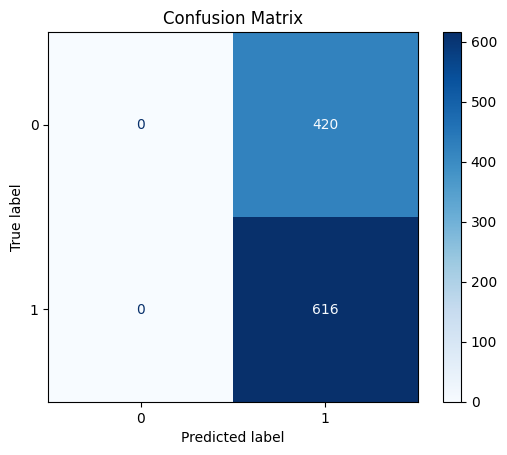

Class 0: 0.00% accuracy
Class 1: 100.00% accuracy


In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient calculation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally normalize it (set normalize='true' for percentages)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# If you want class-wise accuracy:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i, acc in enumerate(np.diag(cm_normalized)):
    print(f"Class {i}: {acc*100:.2f}% accuracy")


Utilizing FocalLoss didn't work. Let us balance out the data and see how that may take affect.

In [65]:
# Get labels from the underlying chart_dataset for each subset
train_labels = [chart_dataset_class[i][1] for i in train_idx]
val_labels   = [chart_dataset_class[i][1] for i in val_idx]
test_labels  = [chart_dataset_class[i][1] for i in test_idx]


In [67]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch

# Make sure labels are integers
train_labels = np.array([int(label) for label in train_labels])

# Define all possible classes explicitly
classes = np.unique(train_labels)
print("Unique labels in training data:", classes)

# Compute class weights safely
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=classes,
                                     y=train_labels)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:", class_weights_tensor)


Unique labels in training data: [0 1]
Class weights: tensor([1.2043, 0.8549], device='cuda:0')


In [71]:
from collections import Counter
train_labels = [chart_dataset_class[i][1] for i in train_idx]
val_labels   = [chart_dataset_class[i][1] for i in val_idx]
test_labels  = [chart_dataset_class[i][1] for i in test_idx]
print("Train counts:", Counter(train_labels))
print("Val counts:  ", Counter(val_labels))
print("Test counts: ", Counter(test_labels))


Train counts: Counter({tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 

In [73]:
from collections import Counter

train_labels = [int(chart_dataset_class[i][1].item()) for i in train_idx]
val_labels   = [int(chart_dataset_class[i][1].item()) for i in val_idx]
test_labels  = [int(chart_dataset_class[i][1].item()) for i in test_idx]

print("Train counts:", Counter(train_labels))
print("Val counts:  ", Counter(val_labels))
print("Test counts: ", Counter(test_labels))


Train counts: Counter({1: 4819, 0: 3421})
Val counts:   Counter({1: 608, 0: 420})
Test counts:  Counter({1: 616, 0: 420})


In [74]:
import numpy as np
import random
from torch.utils.data import Subset

# Get the corresponding labels for train indices
train_labels = [int(chart_dataset_class[i][1].item()) for i in train_idx]

# Split indices by class
class0_idx = [i for i, y in zip(train_idx, train_labels) if y == 0]
class1_idx = [i for i, y in zip(train_idx, train_labels) if y == 1]

print(f"Before undersampling: class0={len(class0_idx)}, class1={len(class1_idx)}")

# Undersample majority class (class 1)
undersampled_class1_idx = random.sample(class1_idx, len(class0_idx))

# Combine and shuffle
balanced_train_idx = class0_idx + undersampled_class1_idx
random.shuffle(balanced_train_idx)

# Create new balanced dataset subset
train_dataset_balanced = Subset(chart_dataset_class, balanced_train_idx)

print(f"After undersampling: total={len(train_dataset_balanced)} (each class={len(class0_idx)})")


Before undersampling: class0=3421, class1=4819
After undersampling: total=6842 (each class=3421)


In [131]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    scaler = torch.cuda.amp.GradScaler()

    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training")):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        y = y.long()

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if batch_idx % 100 == 0:
            print("Scaler scale:", scaler.get_scale())

        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return loss_sum / len(loader.dataset), correct / len(loader.dataset)


In [132]:
train_loader = DataLoader(
    train_dataset_balanced, #train_dataset_balanced
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle=False,
    num_workers = num_workers,
    pin_memory = True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory = True
)

In [133]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

# lr=0.0003


print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_state_dict.pth"

model = CNN_ViT_Hybrid(
    in_channels=3,
    num_classes=num_cls,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = [] 

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch: 02d}/{epochs:02d} started at {present_time()}")
    tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, device) # Former gets the loss, latter gets the acc (just the way it is)
    te_loss, te_acc = evaluate(model, valid_loader, criterion, device)
    ##
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # save the best model 
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)
        
print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


print(f"\nTraining completed!")

# Test on test set
print(f"\n{'='*60}")
print("Testing on held-out test set...")
print(f"{'='*60}")

# Load best model
model.load_state_dict(torch.load(model_dict_name))

# Test
# test_loss = test(model, test_loader, criterion, device)
test_loss, test_acc = test(model, test_loader, criterion, device)
# print(f"\nTest Loss: {test_loss:.6f}")
print(f"\nTest Loss: {test_loss:.6f} | Test Accuracy: {test_acc:.6f}")


Training the model on cuda
epochs:10 | batch:16 | attn_heads:12 | depth:18 | embed_dim:768


C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\1547475344.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch  1/10 started at 20251115_005421


Training:   0%|          | 0/428 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\1547475344.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:   0%|          | 1/428 [00:00<06:38,  1.07it/s]

Scaler scale: 32768.0


Training:  24%|██▎       | 101/428 [02:16<07:37,  1.40s/it]

Scaler scale: 32768.0


Training:  47%|████▋     | 201/428 [04:33<05:04,  1.34s/it]

Scaler scale: 32768.0


Training:  70%|███████   | 301/428 [06:48<02:51,  1.35s/it]

Scaler scale: 32768.0


Training:  94%|█████████▎| 401/428 [09:03<00:36,  1.33s/it]

Scaler scale: 32768.0


Validation:   0%|          | 0/65 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\771255876.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # ✅
Validation: 100%|██████████| 65/65 [00:52<00:00,  1.24it/s]


Epoch 01 | train loss 0.7476 acc 0.5009 | val loss 0.6835 acc 0.5914 | in  632.61s
Current loss (0.6835) lower than previous best loss (inf), Saving current model state

Epoch  2/10 started at 20251115_010454


Training:   0%|          | 1/428 [00:01<09:27,  1.33s/it]

Scaler scale: 65536.0


Training:  24%|██▎       | 101/428 [02:12<07:06,  1.30s/it]

Scaler scale: 32768.0


Training:  47%|████▋     | 201/428 [04:23<04:55,  1.30s/it]

Scaler scale: 32768.0


Training:  70%|███████   | 301/428 [06:33<02:45,  1.30s/it]

Scaler scale: 32768.0


Training:  94%|█████████▎| 401/428 [08:44<00:35,  1.31s/it]

Scaler scale: 32768.0


Validation: 100%|██████████| 65/65 [00:51<00:00,  1.26it/s]


Epoch 02 | train loss 0.7080 acc 0.5042 | val loss 0.7015 acc 0.5914 | in  611.25s

Epoch  3/10 started at 20251115_011505


Training:   0%|          | 1/428 [00:01<08:56,  1.26s/it]

Scaler scale: 65536.0


Training:  24%|██▎       | 101/428 [02:12<07:09,  1.31s/it]

Scaler scale: 32768.0


Training:  47%|████▋     | 201/428 [04:23<04:57,  1.31s/it]

Scaler scale: 32768.0


Training:  70%|███████   | 301/428 [06:35<02:46,  1.31s/it]

Scaler scale: 32768.0


Training:  94%|█████████▎| 401/428 [08:46<00:35,  1.31s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:51<00:00,  1.26it/s]


Epoch 03 | train loss 0.6975 acc 0.5323 | val loss 0.7515 acc 0.4018 | in  613.16s

Epoch  4/10 started at 20251115_012518


Training:   0%|          | 1/428 [00:01<08:55,  1.25s/it]

Scaler scale: 65536.0


Training:  24%|██▎       | 101/428 [02:11<07:09,  1.31s/it]

Scaler scale: 16384.0


Training:  47%|████▋     | 201/428 [04:23<04:57,  1.31s/it]

Scaler scale: 16384.0


Training:  70%|███████   | 301/428 [06:34<02:46,  1.31s/it]

Scaler scale: 16384.0


Training:  94%|█████████▎| 401/428 [08:45<00:35,  1.31s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:51<00:00,  1.26it/s]


Epoch 04 | train loss 0.6760 acc 0.5855 | val loss 0.7296 acc 0.5885 | in  612.34s

Epoch  5/10 started at 20251115_013531


Training:   0%|          | 1/428 [00:01<08:57,  1.26s/it]

Scaler scale: 65536.0


Training:  24%|██▎       | 101/428 [02:11<07:08,  1.31s/it]

Scaler scale: 16384.0


Training:  47%|████▋     | 201/428 [04:22<04:58,  1.32s/it]

Scaler scale: 16384.0


Training:  70%|███████   | 301/428 [06:34<02:46,  1.31s/it]

Scaler scale: 16384.0


Training:  94%|█████████▎| 401/428 [08:45<00:35,  1.31s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:51<00:00,  1.26it/s]


Epoch 05 | train loss 0.6511 acc 0.6272 | val loss 0.7378 acc 0.4484 | in  612.38s

Epoch  6/10 started at 20251115_014543


Training:   0%|          | 1/428 [00:01<08:55,  1.25s/it]

Scaler scale: 65536.0


Training:  24%|██▎       | 101/428 [02:11<06:27,  1.18s/it]

Scaler scale: 16384.0


Training:  47%|████▋     | 201/428 [04:22<04:58,  1.31s/it]

Scaler scale: 8192.0


Training:  70%|███████   | 301/428 [06:33<02:47,  1.32s/it]

Scaler scale: 4096.0


Training:  94%|█████████▎| 401/428 [08:44<00:35,  1.31s/it]

Scaler scale: 4096.0


Validation: 100%|██████████| 65/65 [00:51<00:00,  1.26it/s]


Epoch 06 | train loss 0.6725 acc 0.5839 | val loss 1.0049 acc 0.4115 | in  611.21s

Epoch  7/10 started at 20251115_015554


Training:   0%|          | 1/428 [00:00<05:46,  1.23it/s]

Scaler scale: 32768.0


Training:  24%|██▎       | 101/428 [02:11<07:10,  1.32s/it]

Scaler scale: 16384.0


Training:  47%|████▋     | 201/428 [04:23<04:58,  1.31s/it]

Scaler scale: 16384.0


Training:  70%|███████   | 301/428 [06:34<02:46,  1.31s/it]

Scaler scale: 16384.0


Training:  94%|█████████▎| 401/428 [08:45<00:35,  1.31s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:51<00:00,  1.27it/s]


Epoch 07 | train loss 0.6530 acc 0.6201 | val loss 0.7476 acc 0.4747 | in  611.94s

Epoch  8/10 started at 20251115_020606


Training:   0%|          | 1/428 [00:01<08:52,  1.25s/it]

Scaler scale: 65536.0


Training:  24%|██▎       | 101/428 [02:11<06:58,  1.28s/it]

Scaler scale: 8192.0


Training:  47%|████▋     | 201/428 [04:22<04:57,  1.31s/it]

Scaler scale: 8192.0


Training:  70%|███████   | 301/428 [06:33<02:46,  1.31s/it]

Scaler scale: 8192.0


Training:  94%|█████████▎| 401/428 [08:44<00:35,  1.31s/it]

Scaler scale: 4096.0


Validation: 100%|██████████| 65/65 [00:51<00:00,  1.27it/s]


Epoch 08 | train loss 0.6592 acc 0.6136 | val loss 0.7087 acc 0.5691 | in  610.78s

Epoch  9/10 started at 20251115_021617


Training:   0%|          | 1/428 [00:01<08:56,  1.26s/it]

Scaler scale: 65536.0


Training:  24%|██▎       | 101/428 [02:11<07:08,  1.31s/it]

Scaler scale: 16384.0


Training:  47%|████▋     | 201/428 [04:22<04:52,  1.29s/it]

Scaler scale: 8192.0


Training:  70%|███████   | 301/428 [06:32<02:46,  1.31s/it]

Scaler scale: 2048.0


Training:  94%|█████████▎| 401/428 [08:43<00:35,  1.31s/it]

Scaler scale: 2048.0


Validation: 100%|██████████| 65/65 [00:51<00:00,  1.26it/s]


Epoch 09 | train loss 0.6573 acc 0.6084 | val loss 0.6976 acc 0.5447 | in  610.78s

Epoch  10/10 started at 20251115_022628


Training:   0%|          | 1/428 [00:01<08:55,  1.26s/it]

Scaler scale: 65536.0


Training:  24%|██▎       | 101/428 [02:11<07:09,  1.31s/it]

Scaler scale: 16384.0


Training:  47%|████▋     | 201/428 [04:22<04:57,  1.31s/it]

Scaler scale: 16384.0


Training:  70%|███████   | 301/428 [06:33<02:46,  1.31s/it]

Scaler scale: 16384.0


Training:  94%|█████████▎| 401/428 [08:44<00:35,  1.31s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:51<00:00,  1.27it/s]


Epoch 10 | train loss 0.6513 acc 0.6295 | val loss 0.7445 acc 0.4981 | in  611.42s
epochs:10 | batch:16 | attn_heads:12 | depth:18 | embed_dim:768

Training completed!

Testing on held-out test set...


Testing: 100%|██████████| 65/65 [00:51<00:00,  1.26it/s]


Test Loss: 0.680102 | Test Accuracy: 0.594595


In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient calculation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally normalize it (set normalize='true' for percentages)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# If you want class-wise accuracy:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i, acc in enumerate(np.diag(cm_normalized)):
    print(f"Class {i}: {acc*100:.2f}% accuracy")


NameError: name 'model' is not defined

<Figure size 800x600 with 0 Axes>

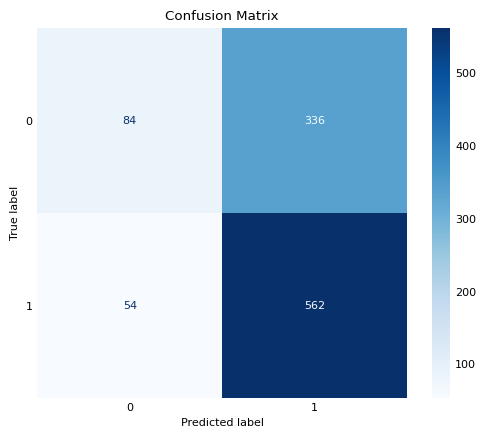

Class 0: 20.00% accuracy
Class 1: 91.23% accuracy


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient calculation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally normalize it (set normalize='true' for percentages)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# If you want class-wise accuracy:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i, acc in enumerate(np.diag(cm_normalized)):
    print(f"Class {i}: {acc*100:.2f}% accuracy")


in train func, addind y = y.long() fixed it.

In [84]:
from collections import Counter

balanced_labels = [int(chart_dataset_class[i][1].item()) for i in balanced_train_idx]
print("Balanced train counts:", Counter(balanced_labels))


Balanced train counts: Counter({0: 3421, 1: 3421})


In [85]:
print(labels.dtype, labels.shape, labels.min().item(), labels.max().item())


torch.int64 torch.Size([12]) 0 1


In [86]:
x, y = next(iter(train_loader))
out = model(x.to(device))
print("Output shape:", out.shape)
print("Sample output:", out[0])


Output shape: torch.Size([32, 2])
Sample output: tensor([-0.2454,  0.1894], device='cuda:0', grad_fn=<SelectBackward0>)


In [90]:
for imgs, labels in train_loader:
    print(labels[:20])
    break


tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1])


In [91]:
model.eval()
with torch.no_grad():
    imgs, labels = next(iter(train_loader))
    imgs = imgs.to(device)
    outputs = model(imgs)
    probs = torch.softmax(outputs, dim=1)
    print("Logits sample:", outputs[:5])
    print("Probs sample:", probs[:5])


Logits sample: tensor([[-0.7903, -0.5659],
        [-0.7883, -0.5658],
        [-0.8020, -0.5518],
        [-0.7958, -0.5592],
        [-0.7972, -0.5563]], device='cuda:0')
Probs sample: tensor([[0.4441, 0.5559],
        [0.4446, 0.5554],
        [0.4378, 0.5622],
        [0.4411, 0.5589],
        [0.4401, 0.5599]], device='cuda:0')


The model aint learning shit.

In [92]:
frozen = [name for name, p in model.named_parameters() if not p.requires_grad]
print("Frozen layers:", frozen)


Frozen layers: []


In [126]:
batch_size  = 16

In [127]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    scaler = torch.cuda.amp.GradScaler()

    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training")):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        y = y.long()

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if batch_idx % 100 == 0:
            print("Scaler scale:", scaler.get_scale())

        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return loss_sum / len(loader.dataset), correct / len(loader.dataset)


In [128]:
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance
    
    Args:
        alpha (float or tensor): Weighting factor in range (0,1) to balance 
                                 positive vs negative examples. Default: 0.25
        gamma (float): Exponent of the modulating factor (1 - p_t)^gamma.
                       Default: 2.0
        reduction (str): 'mean', 'sum' or 'none'. Default: 'mean'
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        """
        Args:
            inputs: (batch_size, num_classes) - raw logits from model
            targets: (batch_size,) - class labels as integers
        """
        # Calculate cross entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Calculate p_t
        p_t = torch.exp(-ce_loss)
        
        # Calculate focal loss
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [129]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

# lr=0.0003


print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_state_dict.pth"

model = CNN_ViT_Hybrid(
    in_channels=3,
    num_classes=num_cls,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)

# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(alpha=0.25, gamma=3.0)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = [] 

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch: 02d}/{epochs:02d} started at {present_time()}")
    tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, device) # Former gets the loss, latter gets the acc (just the way it is)
    te_loss, te_acc = evaluate(model, valid_loader, criterion, device)
    ##
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # save the best model 
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)
        
print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


print(f"\nTraining completed!")

# Test on test set
print(f"\n{'='*60}")
print("Testing on held-out test set...")
print(f"{'='*60}")

# Load best model
model.load_state_dict(torch.load(model_dict_name))

# Test
# test_loss = test(model, test_loader, criterion, device)
test_loss, test_acc = test(model, test_loader, criterion, device)
# print(f"\nTest Loss: {test_loss:.6f}")
print(f"\nTest Loss: {test_loss:.6f} | Test Accuracy: {test_acc:.6f}")


Training the model on cuda
epochs:10 | batch:16 | attn_heads:12 | depth:18 | embed_dim:768


C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\1547475344.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch  1/10 started at 20251114_204221


Training:   0%|          | 0/214 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\1547475344.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:   0%|          | 1/214 [00:09<32:20,  9.11s/it]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [11:44<12:26,  6.60s/it]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [23:41<01:38,  7.56s/it]

Scaler scale: 65536.0


Validation:   0%|          | 0/33 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\771255876.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # ✅
Validation: 100%|██████████| 33/33 [00:43<00:00,  1.31s/it]


Epoch 01 | train loss 0.0503 acc 0.4961 | val loss 0.0213 acc 0.5914 | in  1556.64s
Current loss (0.0213) lower than previous best loss (inf), Saving current model state

Epoch  2/10 started at 20251114_210818


Training:   0%|          | 1/214 [00:04<14:47,  4.17s/it]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [07:04<07:54,  4.20s/it]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [14:04<00:55,  4.24s/it]

Scaler scale: 65536.0


Validation: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]


Epoch 02 | train loss 0.0223 acc 0.4974 | val loss 0.0213 acc 0.5914 | in  936.72s
Current loss (0.0213) lower than previous best loss (0.0213), Saving current model state

Epoch  3/10 started at 20251114_212356


Training:   0%|          | 1/214 [00:04<14:49,  4.17s/it]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [07:02<07:49,  4.15s/it]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [13:58<00:54,  4.16s/it]

Scaler scale: 65536.0


Validation: 100%|██████████| 33/33 [00:38<00:00,  1.18s/it]


Epoch 03 | train loss 0.0224 acc 0.5134 | val loss 0.0258 acc 0.4086 | in  929.22s

Epoch  4/10 started at 20251114_213925


Training:   0%|          | 1/214 [00:04<14:50,  4.18s/it]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [08:31<25:12, 13.38s/it]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [34:50<02:28, 11.42s/it]

Scaler scale: 65536.0


Validation: 100%|██████████| 33/33 [02:04<00:00,  3.76s/it]


Epoch 04 | train loss 0.0222 acc 0.5471 | val loss 0.0226 acc 0.4737 | in  2373.85s

Epoch  5/10 started at 20251114_221859


Training:   0%|          | 1/214 [00:12<43:07, 12.15s/it]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [29:19<26:02, 13.82s/it] 

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [51:57<00:52,  4.03s/it]

Scaler scale: 65536.0


Validation: 100%|██████████| 33/33 [00:41<00:00,  1.26s/it]


Epoch 05 | train loss 0.0211 acc 0.6001 | val loss 0.0234 acc 0.4601 | in  3209.68s

Epoch  6/10 started at 20251114_231228


Training:   0%|          | 1/214 [00:04<14:21,  4.04s/it]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [06:56<06:09,  3.27s/it]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [12:22<00:42,  3.26s/it]

Scaler scale: 65536.0


Validation: 100%|██████████| 33/33 [00:35<00:00,  1.06s/it]


Epoch 06 | train loss 0.0200 acc 0.6478 | val loss 0.0346 acc 0.4056 | in  819.20s

Epoch  7/10 started at 20251114_232608


Training:   0%|          | 1/214 [00:03<11:37,  3.27s/it]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [05:29<06:09,  3.27s/it]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [10:59<00:42,  3.30s/it]

Scaler scale: 65536.0


Validation: 100%|██████████| 33/33 [00:36<00:00,  1.10s/it]


Epoch 07 | train loss 0.0191 acc 0.6795 | val loss 0.0339 acc 0.5895 | in  737.63s

Epoch  8/10 started at 20251114_233825


Training:   0%|          | 1/214 [00:03<11:42,  3.30s/it]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [05:36<06:16,  3.34s/it]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [11:15<00:44,  3.41s/it]

Scaler scale: 65536.0


Validation: 100%|██████████| 33/33 [00:45<00:00,  1.39s/it]


Epoch 08 | train loss 0.0153 acc 0.7847 | val loss 0.0776 acc 0.5914 | in  764.50s

Epoch  9/10 started at 20251114_235110


Training:   0%|          | 1/214 [00:03<11:58,  3.37s/it]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [05:40<06:19,  3.36s/it]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [11:15<00:44,  3.42s/it]

Scaler scale: 65536.0


Validation: 100%|██████████| 33/33 [00:46<00:00,  1.42s/it]


Epoch 09 | train loss 0.0106 acc 0.8686 | val loss 0.1902 acc 0.4086 | in  765.70s

Epoch  10/10 started at 20251115_000355


Training:   0%|          | 1/214 [00:03<12:21,  3.48s/it]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [05:43<06:39,  3.53s/it]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [11:26<00:44,  3.40s/it]

Scaler scale: 65536.0


Validation: 100%|██████████| 33/33 [00:45<00:00,  1.39s/it]


Epoch 10 | train loss 0.0065 acc 0.9281 | val loss 0.0931 acc 0.4543 | in  775.56s
epochs:10 | batch:16 | attn_heads:12 | depth:18 | embed_dim:768

Training completed!

Testing on held-out test set...


Testing: 100%|██████████| 33/33 [00:54<00:00,  1.66s/it]


Test Loss: 0.021228 | Test Accuracy: 0.594595


<Figure size 800x600 with 0 Axes>

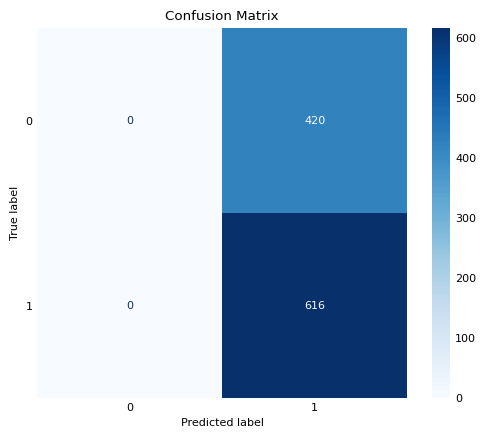

Class 0: 0.00% accuracy
Class 1: 100.00% accuracy


In [130]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient calculation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally normalize it (set normalize='true' for percentages)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# If you want class-wise accuracy:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i, acc in enumerate(np.diag(cm_normalized)):
    print(f"Class {i}: {acc*100:.2f}% accuracy")


In [134]:
train_loader = DataLoader(
    train_dataset,  # <-- The full, original dataset
    batch_size=batch_size, # This is 16 now
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

In [135]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    scaler = torch.cuda.amp.GradScaler()

    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training")):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        y = y.long()

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if batch_idx % 100 == 0:
            print("Scaler scale:", scaler.get_scale())

        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return loss_sum / len(loader.dataset), correct / len(loader.dataset)


In [136]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

# lr=0.0003


print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_state_dict.pth"

model = CNN_ViT_Hybrid(
    in_channels=3,
    num_classes=num_cls,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)


class_weights = torch.tensor([1.2043, 0.8549], dtype=torch.float).to(device)

# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights) # <-- This is the key

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = [] 

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch: 02d}/{epochs:02d} started at {present_time()}")
    tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, device) # Former gets the loss, latter gets the acc (just the way it is)
    te_loss, te_acc = evaluate(model, valid_loader, criterion, device)
    ##
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # save the best model 
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)
        
print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


print(f"\nTraining completed!")

# Test on test set
print(f"\n{'='*60}")
print("Testing on held-out test set...")
print(f"{'='*60}")

# Load best model
model.load_state_dict(torch.load(model_dict_name))

# Test
# test_loss = test(model, test_loader, criterion, device)
test_loss, test_acc = test(model, test_loader, criterion, device)
# print(f"\nTest Loss: {test_loss:.6f}")
print(f"\nTest Loss: {test_loss:.6f} | Test Accuracy: {test_acc:.6f}")


Training the model on cuda
epochs:10 | batch:16 | attn_heads:12 | depth:18 | embed_dim:768


C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\1547475344.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch  1/10 started at 20251115_023732


Training:   0%|          | 0/515 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\1547475344.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:   0%|          | 1/515 [00:02<25:02,  2.92s/it]

Scaler scale: 65536.0


Training:  20%|█▉        | 101/515 [02:44<11:29,  1.66s/it]

Scaler scale: 32768.0


Training:  39%|███▉      | 201/515 [05:26<08:27,  1.62s/it]

Scaler scale: 32768.0


Training:  58%|█████▊    | 301/515 [08:08<05:44,  1.61s/it]

Scaler scale: 32768.0


Training:  78%|███████▊  | 401/515 [10:49<03:02,  1.60s/it]

Scaler scale: 32768.0


Training:  97%|█████████▋| 501/515 [13:30<00:22,  1.62s/it]

Scaler scale: 32768.0


Validation:   0%|          | 0/65 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_27916\771255876.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # ✅
Validation: 100%|██████████| 65/65 [00:50<00:00,  1.28it/s]


Epoch 01 | train loss 0.7556 acc 0.4933 | val loss 0.7406 acc 0.5914 | in  884.41s
Current loss (0.7406) lower than previous best loss (inf), Saving current model state

Epoch  2/10 started at 20251115_025217


Training:   0%|          | 1/515 [00:01<13:38,  1.59s/it]

Scaler scale: 65536.0


Training:  20%|█▉        | 101/515 [02:39<10:56,  1.59s/it]

Scaler scale: 32768.0


Training:  39%|███▉      | 201/515 [05:18<08:17,  1.58s/it]

Scaler scale: 32768.0


Training:  58%|█████▊    | 301/515 [07:56<05:39,  1.59s/it]

Scaler scale: 32768.0


Training:  78%|███████▊  | 401/515 [10:35<03:00,  1.58s/it]

Scaler scale: 32768.0


Training:  97%|█████████▋| 501/515 [13:13<00:22,  1.58s/it]

Scaler scale: 32768.0


Validation: 100%|██████████| 65/65 [00:50<00:00,  1.28it/s]


Epoch 02 | train loss 0.7041 acc 0.5205 | val loss 0.7028 acc 0.4037 | in  866.79s
Current loss (0.7028) lower than previous best loss (0.7406), Saving current model state

Epoch  3/10 started at 20251115_030644


Training:   0%|          | 1/515 [00:01<13:36,  1.59s/it]

Scaler scale: 65536.0


Training:  20%|█▉        | 101/515 [02:39<10:56,  1.59s/it]

Scaler scale: 32768.0


Training:  39%|███▉      | 201/515 [05:18<08:19,  1.59s/it]

Scaler scale: 32768.0


Training:  58%|█████▊    | 301/515 [07:56<05:40,  1.59s/it]

Scaler scale: 32768.0


Training:  78%|███████▊  | 401/515 [10:35<03:00,  1.58s/it]

Scaler scale: 32768.0


Training:  97%|█████████▋| 501/515 [13:13<00:22,  1.58s/it]

Scaler scale: 32768.0


Validation: 100%|██████████| 65/65 [00:50<00:00,  1.28it/s]


Epoch 03 | train loss 0.6962 acc 0.5313 | val loss 0.7197 acc 0.5749 | in  866.91s

Epoch  4/10 started at 20251115_032111


Training:   0%|          | 1/515 [00:01<13:38,  1.59s/it]

Scaler scale: 65536.0


Training:  20%|█▉        | 101/515 [02:39<10:57,  1.59s/it]

Scaler scale: 32768.0


Training:  39%|███▉      | 201/515 [05:17<08:18,  1.59s/it]

Scaler scale: 8192.0


Training:  58%|█████▊    | 301/515 [07:55<05:40,  1.59s/it]

Scaler scale: 8192.0


Training:  78%|███████▊  | 401/515 [10:34<03:01,  1.59s/it]

Scaler scale: 8192.0


Training:  97%|█████████▋| 501/515 [13:13<00:22,  1.58s/it]

Scaler scale: 8192.0


Validation: 100%|██████████| 65/65 [00:50<00:00,  1.28it/s]


Epoch 04 | train loss 0.6929 acc 0.5413 | val loss 0.7300 acc 0.4018 | in  866.16s

Epoch  5/10 started at 20251115_033537


Training:   0%|          | 1/515 [00:01<13:36,  1.59s/it]

Scaler scale: 65536.0


Training:  20%|█▉        | 101/515 [02:39<10:57,  1.59s/it]

Scaler scale: 16384.0


Training:  39%|███▉      | 201/515 [05:20<09:04,  1.73s/it]

Scaler scale: 16384.0


Training:  58%|█████▊    | 301/515 [08:13<06:10,  1.73s/it]

Scaler scale: 16384.0


Training:  78%|███████▊  | 401/515 [11:06<03:17,  1.73s/it]

Scaler scale: 16384.0


Training:  97%|█████████▋| 501/515 [13:58<00:24,  1.73s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:59<00:00,  1.09it/s]


Epoch 05 | train loss 0.6949 acc 0.5400 | val loss 0.7342 acc 0.4086 | in  922.65s

Epoch  6/10 started at 20251115_035100


Training:   0%|          | 1/515 [00:01<10:18,  1.20s/it]

Scaler scale: 32768.0


Training:  20%|█▉        | 101/515 [02:44<11:17,  1.64s/it]

Scaler scale: 16384.0


Training:  39%|███▉      | 201/515 [05:28<08:35,  1.64s/it]

Scaler scale: 16384.0


Training:  58%|█████▊    | 301/515 [08:12<05:48,  1.63s/it]

Scaler scale: 16384.0


Training:  78%|███████▊  | 401/515 [10:56<03:06,  1.63s/it]

Scaler scale: 16384.0


Training:  97%|█████████▋| 501/515 [13:40<00:22,  1.62s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:50<00:00,  1.29it/s]


Epoch 06 | train loss 0.6913 acc 0.5408 | val loss 0.7021 acc 0.4553 | in  893.89s
Current loss (0.7021) lower than previous best loss (0.7028), Saving current model state

Epoch  7/10 started at 20251115_040554


Training:   0%|          | 1/515 [00:01<13:35,  1.59s/it]

Scaler scale: 65536.0


Training:  20%|█▉        | 101/515 [02:39<10:55,  1.58s/it]

Scaler scale: 16384.0


Training:  39%|███▉      | 201/515 [05:17<08:17,  1.59s/it]

Scaler scale: 16384.0


Training:  58%|█████▊    | 301/515 [07:56<05:39,  1.59s/it]

Scaler scale: 16384.0


Training:  78%|███████▊  | 401/515 [10:34<03:00,  1.58s/it]

Scaler scale: 16384.0


Training:  97%|█████████▋| 501/515 [13:13<00:22,  1.58s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:50<00:00,  1.28it/s]


Epoch 07 | train loss 0.6918 acc 0.5381 | val loss 0.6948 acc 0.5875 | in  866.24s
Current loss (0.6948) lower than previous best loss (0.7021), Saving current model state

Epoch  8/10 started at 20251115_042021


Training:   0%|          | 1/515 [00:01<13:40,  1.60s/it]

Scaler scale: 65536.0


Training:  20%|█▉        | 101/515 [02:39<10:56,  1.59s/it]

Scaler scale: 16384.0


Training:  39%|███▉      | 201/515 [05:17<08:17,  1.58s/it]

Scaler scale: 16384.0


Training:  58%|█████▊    | 301/515 [07:56<05:38,  1.58s/it]

Scaler scale: 16384.0


Training:  78%|███████▊  | 401/515 [10:34<03:01,  1.59s/it]

Scaler scale: 16384.0


Training:  97%|█████████▋| 501/515 [13:13<00:22,  1.59s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:50<00:00,  1.29it/s]


Epoch 08 | train loss 0.6900 acc 0.5442 | val loss 0.7185 acc 0.4280 | in  865.96s

Epoch  9/10 started at 20251115_043447


Training:   0%|          | 1/515 [00:01<13:32,  1.58s/it]

Scaler scale: 65536.0


Training:  20%|█▉        | 101/515 [02:39<10:55,  1.58s/it]

Scaler scale: 16384.0


Training:  39%|███▉      | 201/515 [05:17<08:17,  1.59s/it]

Scaler scale: 16384.0


Training:  58%|█████▊    | 301/515 [07:56<05:38,  1.58s/it]

Scaler scale: 16384.0


Training:  78%|███████▊  | 401/515 [10:34<03:00,  1.59s/it]

Scaler scale: 16384.0


Training:  97%|█████████▋| 501/515 [13:13<00:22,  1.58s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:50<00:00,  1.28it/s]


Epoch 09 | train loss 0.6813 acc 0.5718 | val loss 0.7560 acc 0.4533 | in  865.97s

Epoch  10/10 started at 20251115_044913


Training:   0%|          | 1/515 [00:01<13:33,  1.58s/it]

Scaler scale: 65536.0


Training:  20%|█▉        | 101/515 [02:39<10:56,  1.59s/it]

Scaler scale: 32768.0


Training:  39%|███▉      | 201/515 [05:17<08:17,  1.58s/it]

Scaler scale: 16384.0


Training:  58%|█████▊    | 301/515 [07:55<05:39,  1.59s/it]

Scaler scale: 16384.0


Training:  78%|███████▊  | 401/515 [10:34<03:00,  1.59s/it]

Scaler scale: 16384.0


Training:  97%|█████████▋| 501/515 [13:13<00:22,  1.58s/it]

Scaler scale: 16384.0


Validation: 100%|██████████| 65/65 [00:50<00:00,  1.29it/s]


Epoch 10 | train loss 0.6772 acc 0.5799 | val loss 0.7201 acc 0.4144 | in  865.81s
epochs:10 | batch:16 | attn_heads:12 | depth:18 | embed_dim:768

Training completed!

Testing on held-out test set...


Testing: 100%|██████████| 65/65 [01:00<00:00,  1.07it/s]


Test Loss: 0.688580 | Test Accuracy: 0.576255


If this doesnt work, upload this on github, split up the files (classificaion and prediction). Restart.

UPUPUPUPUP is probably going to be the case/